In [142]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import Huber
import tensorflow as tf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(22)
random.seed(22)
tf.random.set_seed(22)

# Load data
df = pd.read_csv('all_numerical_only_indie.csv', index_col='name')

In [143]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=22)

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the training data (fit on training data only to avoid data leakage)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Scale the test data using the same scaler (to maintain consistency)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [144]:
def create_autoencoder(latent_space_size):
    input_layer = layers.Input(shape=(X_train_scaled.shape[1],))  # Same as input data shape

    # Encoder
    encoded = layers.Dense(latent_space_size, activation='relu')(input_layer)
    # Decoder
    decoded = layers.Dense(X_train_scaled.shape[1], activation='sigmoid')(encoded)

    # Create the model
    autoencoder = Model(input_layer, decoded)

    # Compile the model
    autoencoder.compile(optimizer='adam', loss=Huber())
    
    return autoencoder, input_layer, encoded

In [145]:
#Latent space sizes to experiment with
# latent_space_sizes = [8, 16, 32]

# # Dictionary to store the results
# results = {}

# for latent_size in latent_space_sizes:
#     print(f"\nTraining Autoencoder with Latent Space Size: {latent_size}")
    
#     # Create and train the autoencoder
#     autoencoder, input_layer, encoded = create_autoencoder(latent_size)
#     history = autoencoder.fit(X_train_scaled, X_train_scaled,
#                               validation_data=(X_test_scaled, X_test_scaled),
#                               epochs=50, batch_size=256, shuffle=True, verbose=0)
    
#     # Store the final val_loss for comparison
#     final_val_loss = history.history['val_loss'][-1]
#     results[latent_size] = final_val_loss
#     print(f"Final Validation Loss for Latent Size {latent_size}: {final_val_loss}")

In [146]:
# for latent_size, val_loss in results.items():
#     print(f"Latent Space Size: {latent_size}, Validation Loss: {val_loss}")

In [147]:
autoencoder, input_layer, encoded = create_autoencoder(16)

# Fit the autoencoder model
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          validation_data=(X_test_scaled, X_test_scaled),
                          epochs=50, batch_size=256, shuffle=True, verbose=0)

# Create the encoder model to extract the latent features
encoder = Model(input_layer, encoded)

# Get the latent features for both train and test data
X_train_latent = encoder.predict(X_train_scaled)
X_test_latent = encoder.predict(X_test_scaled)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


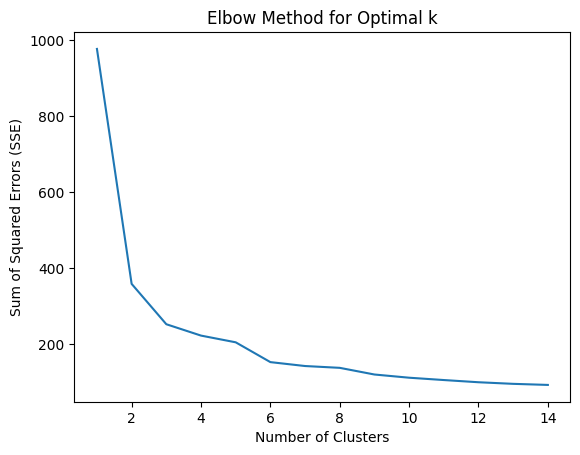

In [148]:
sse = []

# Try different values of k (number of clusters)
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=22)
    kmeans.fit(X_train_latent)  # Use latent features for clustering
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 15), sse)
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.show()

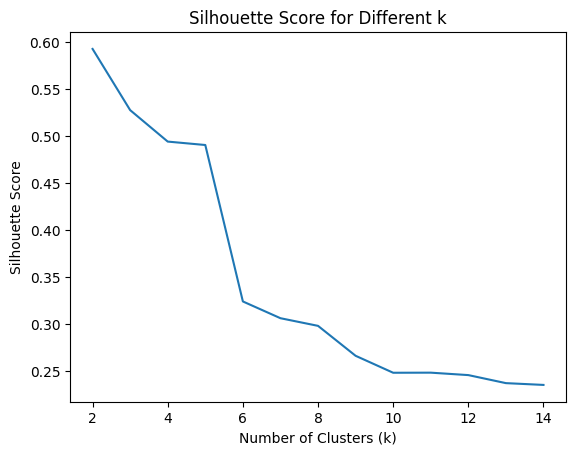

The best number of clusters (k) is: 2


In [149]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# List to store silhouette scores
k_sil_scores = []

# Try different values of k (number of clusters)
for k in range(2, 15):  # You can try different ranges depending on your data
    kmeans = KMeans(n_clusters=k, random_state=22)
    kmeans.fit(X_train_latent)  # Fit K-means on the latent features
    cluster_labels = kmeans.labels_
    
    # Calculate silhouette score
    score = silhouette_score(X_train_latent, cluster_labels)
    k_sil_scores.append(score)

# Plot silhouette scores for different k values
plt.plot(range(2, 15), k_sil_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.savefig('Graphs/silhouette_score_vs_k.png', dpi=300, bbox_inches='tight')
plt.show()

# Find the best k (the one with the highest silhouette score)
best_k = range(2, 15)[k_sil_scores.index(max(k_sil_scores))]
print(f"The best number of clusters (k) is: {best_k}")

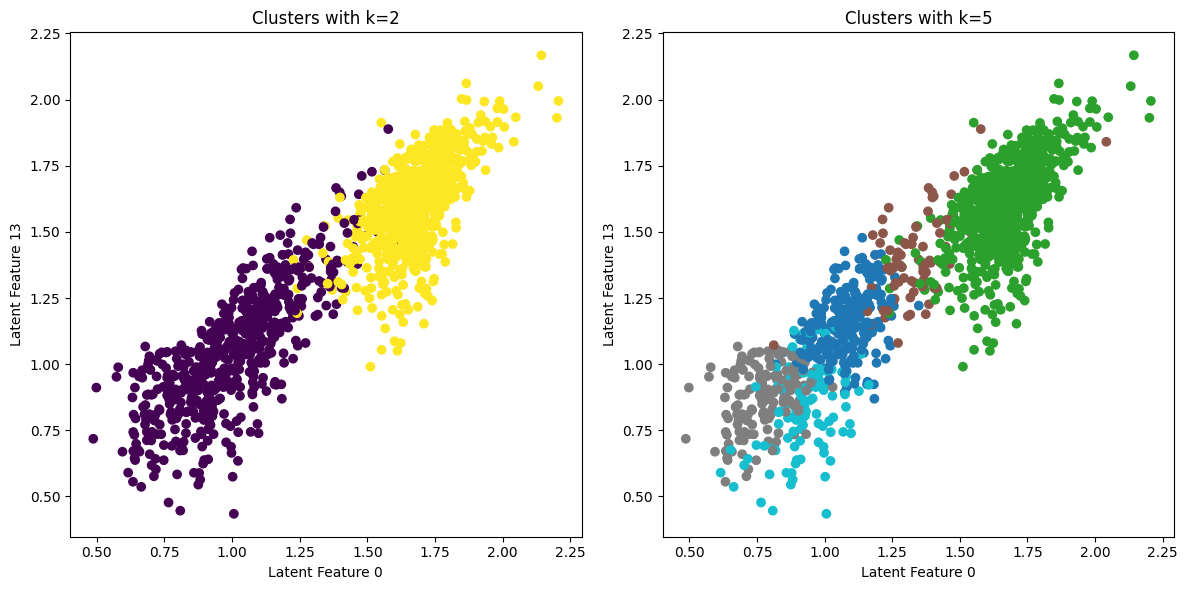

In [150]:
# Perform K-means clustering with k=2 and k=7
kmeans_2 = KMeans(n_clusters=2, random_state=22)
kmeans_2.fit(X_train_latent)
cluster_labels_2 = kmeans_2.labels_

kmeans_5 = KMeans(n_clusters=5, random_state=22)
kmeans_5.fit(X_train_latent)
cluster_labels_5 = kmeans_5.labels_

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for k=2
axs[0].scatter(X_train_latent[:, 0], X_train_latent[:, 13], c=cluster_labels_2, cmap='viridis')
axs[0].set_title('Clusters with k=2')
axs[0].set_xlabel('Latent Feature 0')
axs[0].set_ylabel('Latent Feature 13')

# Plot for k=7
axs[1].scatter(X_train_latent[:, 0], X_train_latent[:, 13], c=cluster_labels_5, cmap='tab10')
axs[1].set_title('Clusters with k=5')
axs[1].set_xlabel('Latent Feature 0')
axs[1].set_ylabel('Latent Feature 13')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('Graphs/k=2 k=5 indie scatter.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [151]:
cluster_sizes_2 = [sum(cluster_labels_2 == i) for i in range(2)]
print(f"Cluster sizes for k=2: {cluster_sizes_2}")

# For k=7
cluster_sizes_5 = [sum(cluster_labels_5 == i) for i in range(5)]
print(f"Cluster sizes for k=5: {cluster_sizes_5}")

Cluster sizes for k=2: [606, 766]
Cluster sizes for k=5: [258, 764, 84, 155, 111]


In [152]:
# Convert the latent space (X_train_latent) to a DataFrame
df_k2 = pd.DataFrame(X_train_latent)  # Convert to DataFrame
df_k5 = pd.DataFrame(X_train_latent)

# Add cluster labels to the DataFrame
df_k2['Cluster_Labels_2'] = cluster_labels_2  # Add the cluster labels for k=2
df_k5['Cluster_Labels_5'] = cluster_labels_5  # Add the cluster labels for k=7

# Calculate the mean values for each feature per cluster (k=2)
cluster_means_2 = df_k2.groupby('Cluster_Labels_2').mean()

# Calculate the mean values for each feature per cluster (k=7)
cluster_means_5 = df_k5.groupby('Cluster_Labels_5').mean()

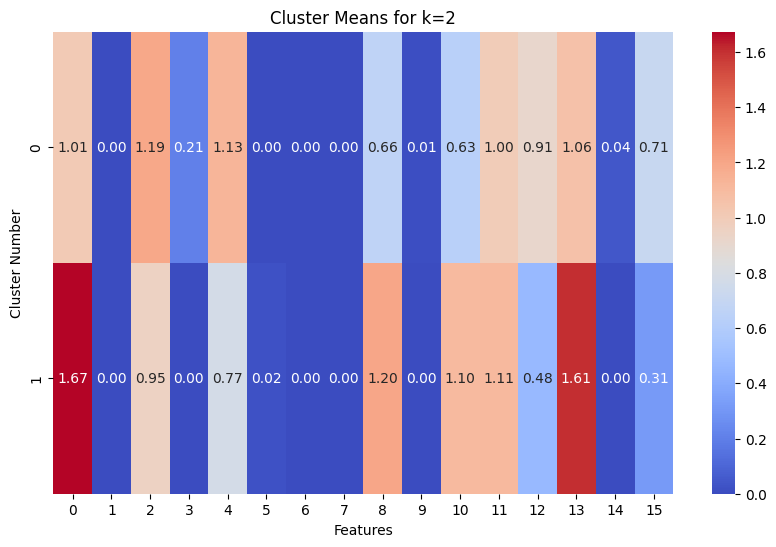

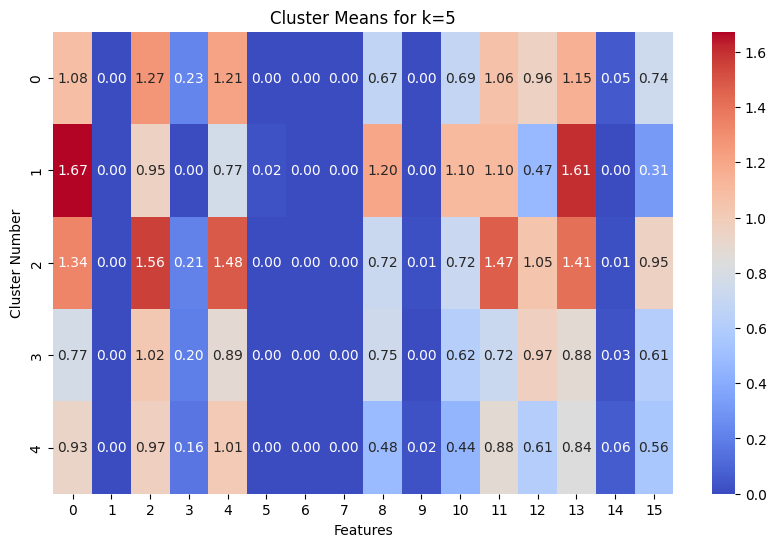

In [153]:
import seaborn as sns
# Heatmap for k=2
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_2, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Cluster Means for k=2")
plt.xlabel("Features")
plt.ylabel("Cluster Number")
plt.savefig('Graphs/k=2_indie_latent.png', dpi=300, bbox_inches='tight')
plt.show()

# Heatmap for k=7
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_5, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Cluster Means for k=5")
plt.xlabel("Features")
plt.ylabel("Cluster Number")
plt.savefig('Graphs/k=5_indie_latent.png', dpi=300, bbox_inches='tight')
plt.show()

In [154]:
test_labels_5 = kmeans_5.predict(X_test_latent)
print(test_labels_5)

[1 3 1 0 1 3 1 0 0 1 4 3 1 1 3 0 1 3 1 1 3 0 1 1 1 1 0 1 0 1 1 3 3 0 1 1 3
 1 1 3 3 1 1 3 1 1 4 2 2 1 1 1 3 2 0 1 3 1 1 0 1 0 1 1 3 1 1 1 4 1 1 0 1 1
 0 4 1 3 0 4 1 1 1 1 1 1 4 1 1 0 0 2 1 0 1 4 0 1 1 1 1 3 4 0 1 1 2 2 1 1 1
 1 4 1 1 1 1 1 1 0 1 1 1 4 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 4 1 1 3 1 0 1 1 0
 4 4 3 0 4 4 0 1 1 1 4 1 1 1 3 1 3 0 1 1 0 3 2 3 4 0 1 1 0 1 0 2 0 1 4 0 1
 3 1 1 4 3 1 1 1 1 1 1 1 2 2 1 1 0 1 1 1 1 1 3 0 1 1 1 1 1 1 0 3 1 1 0 1 1
 1 1 3 3 0 1 1 1 1 3 1 1 3 1 1 1 0 4 1 0 1 1 3 1 3 1 0 1 1 1 1 0 1 0 1 1 2
 1 1 0 0 4 0 1 2 0 2 0 1 1 2 1 0 3 1 1 0 4 0 1 3 1 0 1 0 2 0 1 4 0 0 3 1 1
 0 1 3 3 0 2 1 0 1 0 0 1 1 1 1 0 2 3 1 0 4 0 3 1 3 0 1 1 1 0 1 1 1 0 1 4 2
 1 2 1 1 1 1 4 0 1 1]


In [155]:
cluster_test_5 = [sum(test_labels_5 == i) for i in range(5)]
print(f"Cluster sizes on test data for k=5: {cluster_test_5}")

Cluster sizes on test data for k=5: [68, 189, 19, 41, 26]


In [156]:
total_cluster_size = [a + b for a, b in zip(cluster_sizes_5, cluster_test_5)]
print(total_cluster_size)

[326, 953, 103, 196, 137]


    Num_Clusters  Silhouette_Score
0              2          0.593018
1              3          0.466237
2              4          0.414338
3              5          0.409942
4              6          0.173301
5              7          0.165441
6              8          0.159510
7              9          0.063394
8             10          0.061725
9             11          0.041894
10            12          0.027100
11            13          0.016104
12            14         -0.010651


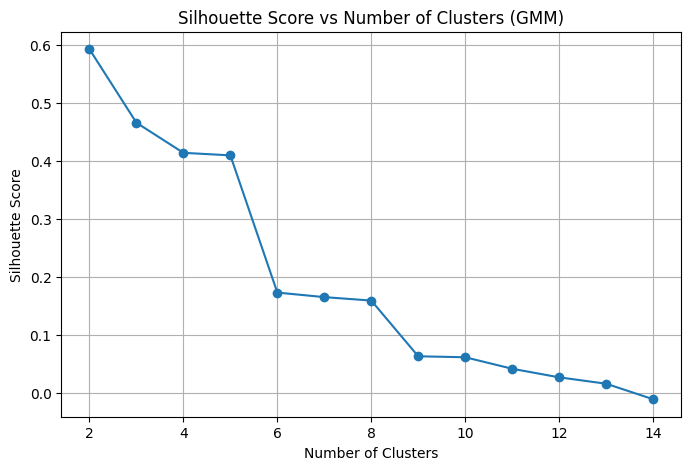

In [157]:
#GAUSSIAN MEANS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of cluster sizes to test
cluster_range = range(2, 15)  # Test from 2 to 14 clusters

# To store results
results = []

for n_clusters in cluster_range:
    # Train GMM with the specified number of clusters
    gmm = GaussianMixture(n_components=n_clusters, random_state=22)
    gmm_labels = gmm.fit_predict(X_train_latent)
    
    # Compute silhouette score for the clustering
    if n_clusters > 1:  # Silhouette score is not defined for 1 cluster
        sil_score = silhouette_score(X_train_latent, gmm_labels)
    else:
        sil_score = np.nan
    
    # Store results for each cluster size
    results.append((n_clusters, sil_score))

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=["Num_Clusters", "Silhouette_Score"])

# Display results
print(results_df)

# Optional: Visualize silhouette scores across cluster sizes
plt.figure(figsize=(8, 5))
plt.plot(results_df["Num_Clusters"], results_df["Silhouette_Score"], marker='o')
plt.title("Silhouette Score vs Number of Clusters (GMM)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.savefig('Graphs/gmm silhouette vs clusters.png', dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

In [158]:
from sklearn.mixture import GaussianMixture
cluster_sizes = [2, 5]

# Create a dictionary to store the labels for each cluster size
cluster_labels = {}

for n_clusters in cluster_sizes:
    # Train GMM with the specified number of clusters
    gmm = GaussianMixture(n_components=n_clusters, random_state=22)
    
    # Fit the model and predict cluster labels for the training data
    gmm_labels = gmm.fit_predict(X_train_latent)
    
    # Store the labels for each number of clusters
    cluster_labels[n_clusters] = gmm_labels
    
    # Print the cluster labels for the current number of clusters
    print(f"Cluster labels for {n_clusters} clusters:")
    print(pd.Series(gmm_labels).value_counts())  # Display cluster counts

# Example: Accessing the labels for 2 and 5 clusters
labels_2_clusters = cluster_labels[2]
labels_5_clusters = cluster_labels[5]

# Optional: Display the labels for both cluster sizes
print("Labels for 2 clusters:", labels_2_clusters)
print("Labels for 5 clusters:", labels_5_clusters)

Cluster labels for 2 clusters:
1    765
0    607
Name: count, dtype: int64
Cluster labels for 5 clusters:
1    764
3    336
0    164
4     65
2     43
Name: count, dtype: int64
Labels for 2 clusters: [0 0 1 ... 1 0 1]
Labels for 5 clusters: [4 0 1 ... 1 0 1]


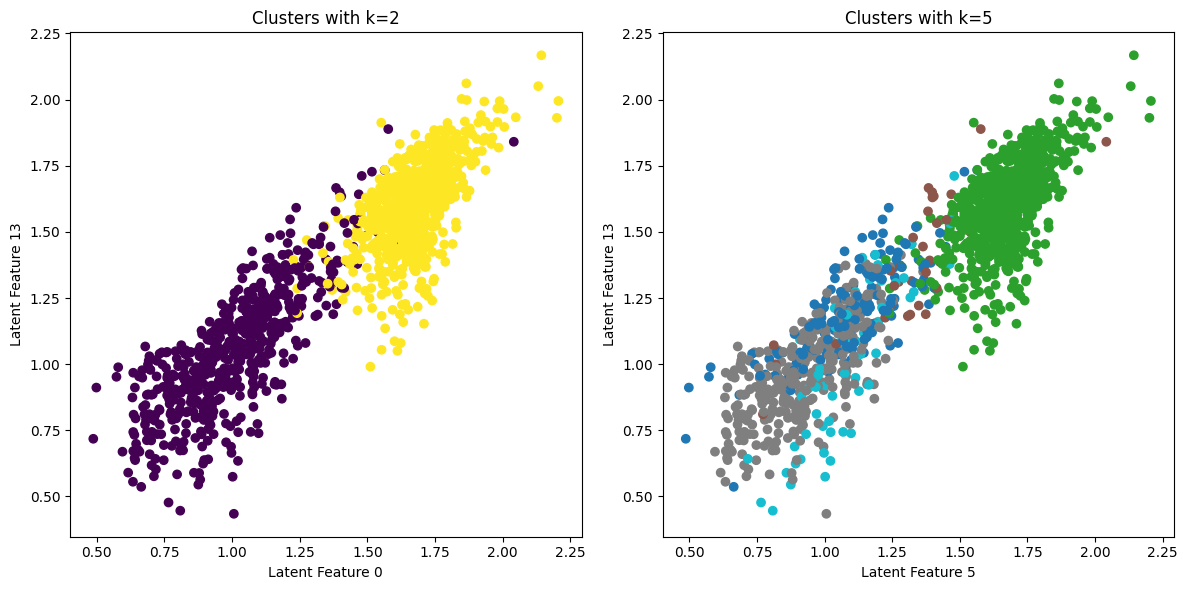

In [159]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for k=2
axs[0].scatter(X_train_latent[:, 0], X_train_latent[:, 13], c=labels_2_clusters, cmap='viridis')
axs[0].set_title('Clusters with k=2')
axs[0].set_xlabel('Latent Feature 0')
axs[0].set_ylabel('Latent Feature 13')

# Plot for k=7
axs[1].scatter(X_train_latent[:, 0], X_train_latent[:, 13], c=labels_5_clusters, cmap='tab10')
axs[1].set_title('Clusters with k=5')
axs[1].set_xlabel('Latent Feature 5')
axs[1].set_ylabel('Latent Feature 13')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('Graphs/k=2 k=5 indie scatter gaussian.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [160]:
#DB SCAN CLUSTERING
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Define a range of eps values to test
eps_values = np.arange(0.5, 1.0, 0.05)  # Adjust range as needed

results = []

for eps in eps_values:
    # Run DBSCAN with the current eps value
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_train_latent)
    
    # Count number of clusters (excluding noise points labeled as -1)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Count the number of noise points (-1 labels)
    num_noise = list(labels).count(-1)
    
    if num_clusters > 1:
        mask = labels != -1  # Ignore noise points
        sil_score = silhouette_score(X_train_latent[mask], labels[mask])
    else:
        sil_score = np.nan  # Not computable
    
    # Store the results
    results.append((eps, num_clusters, sil_score, num_noise))
    
    print(f"Results for eps={eps}")
    print(pd.Series(labels).value_counts())  # Shows the distribution of clusters and noise

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=["Eps", "Num_Clusters", "Silhouette_Score", "Num_Noise"])

Results for eps=0.5
 1    763
 0    600
-1      9
Name: count, dtype: int64
Results for eps=0.55
 1    763
 0    603
-1      6
Name: count, dtype: int64
Results for eps=0.6000000000000001
 1    763
 0    604
-1      5
Name: count, dtype: int64
Results for eps=0.6500000000000001
 1    764
 0    604
-1      4
Name: count, dtype: int64
Results for eps=0.7000000000000002
 1    764
 0    605
-1      3
Name: count, dtype: int64
Results for eps=0.7500000000000002
 1    764
 0    606
-1      2
Name: count, dtype: int64
Results for eps=0.8000000000000003
 1    764
 0    607
-1      1
Name: count, dtype: int64
Results for eps=0.8500000000000003
1    764
0    608
Name: count, dtype: int64
Results for eps=0.9000000000000004
0    1372
Name: count, dtype: int64
Results for eps=0.9500000000000004
0    1372
Name: count, dtype: int64


In [161]:
# Display results
print(results_df)

    Eps  Num_Clusters  Silhouette_Score  Num_Noise
0  0.50             2          0.596941          9
1  0.55             2          0.596130          6
2  0.60             2          0.595631          5
3  0.65             2          0.595161          4
4  0.70             2          0.594851          3
5  0.75             2          0.593958          2
6  0.80             2          0.593795          1
7  0.85             2          0.592995          0
8  0.90             1               NaN          0
9  0.95             1               NaN          0


In [162]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# # Assuming you have the cluster labels for the latent features (e.g., gmm_labels)
# # and the original data (X_train)
# X_train_clustered = X_train.copy()  # Make a copy of the original data
# X_train_clustered['Cluster'] = cluster_labels_5  # Add the cluster labels as a new column

# # Step 2: Visualize the clusters using pairplot (for 2D or 3D visualization)
# sns.pairplot(X_train_clustered, hue='Cluster', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.3})
# plt.title("Pairplot of Original Features with Cluster Labels")
# plt.savefig('Clusters vs original features.png', dpi=300, bbox_inches='tight')
# plt.show()


In [163]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming you have the cluster labels for the latent features (e.g., gmm_labels)
# # and the original data (X_train)
# X_train_clustered = X_train.copy()  # Make a copy of the original data
# X_train_clustered['Cluster'] = cluster_labels_2  # Add the cluster labels as a new column

# # Step 2: Visualize the clusters using pairplot (for 2D or 3D visualization)
# sns.pairplot(X_train_clustered, hue='Cluster', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.3})
# plt.title("Pairplot of Original Features with Cluster Labels (2 Clusters)")
# plt.savefig('Clusters vs original features (2 Clusters).png', dpi=300, bbox_inches='tight')
# plt.show()

In [164]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming you have the cluster labels for the latent features (e.g., gmm_labels)
# # and the original data (X_train)
# X_train_clustered = X_train.copy()  # Make a copy of the original data
# X_train_clustered['Cluster'] = labels_2_clusters  # Add the cluster labels as a new column

# # Step 2: Visualize the clusters using pairplot (for 2D or 3D visualization)
# sns.pairplot(X_train_clustered, hue='Cluster', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.3})
# plt.title("Pairplot of Original Features with Cluster Labels (2 Clusters Gaussian)")
# plt.savefig('Clusters vs original features (2 Clusters Gaussian).png', dpi=300, bbox_inches='tight')
# plt.show()

In [169]:
from sklearn.ensemble import RandomForestClassifier

# X_train: Original features
# y_train_clusters: Cluster labels predicted earlier (based on latent variables)

rf = RandomForestClassifier(n_estimators=100, random_state=22)
rf.fit(X_train, labels_2_clusters)

RandomForestClassifier(random_state=22)

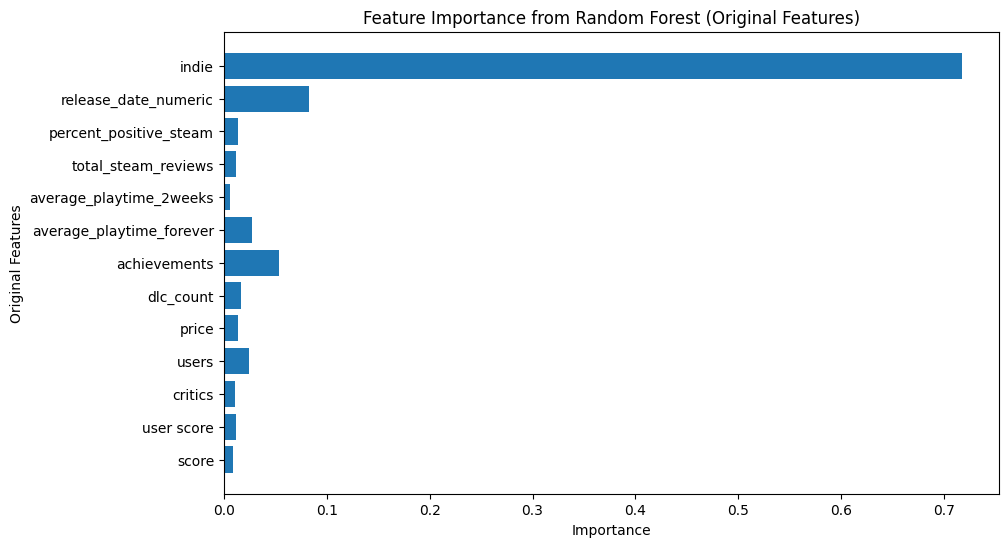

In [170]:
# Get feature importances
importances = rf.feature_importances_

# Visualize feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), X_train.columns)  # Using the original feature names
plt.title("Feature Importance from Random Forest (Original Features)")
plt.xlabel("Importance")
plt.ylabel("Original Features")
plt.savefig('Feature Importance (Original, Indie Only k=2).png', dpi=300, bbox_inches='tight')
plt.show()

In [167]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.hist(df['score'], bins=30, color='blue', alpha=0.7, label='Original Feature 0')
# plt.title('User Score')

# plt.subplot(1, 2, 2)
# plt.hist(X_train_latent[:, 0], bins=30, color='green', alpha=0.7, label='Latent Space Feature 1')
# plt.title('Latent Space Feature 1')
# plt.show()